# 回归模型，任务场景：超短期光伏出力预测

## 0 远程拉取github项目（本地运行时不要运行这部分,可将这部分全部注释）

In [ ]:
# ===== 第 0 步：初始化项目  =====
import os

REPO_NAME = "sjtu-ML"                                    #仓库名称
REPO_URL  = "https://github.com/sihaobao/sjtu-ML.git"    #github仓库地址

# 1. 如果仓库不存在，则 clone
if not os.path.exists(f"/content/{REPO_NAME}"):
    !git clone {REPO_URL}

# 2. 切换到 google colab 中的仓库根目录
os.chdir(f"/content/{REPO_NAME}")

# 3. 切换到当前实验目录（数据就在这里）
os.chdir("第二章-回归模型")

print("✅ 当前工作目录：", os.getcwd())
print("✅ 当前目录文件：", os.listdir("."))


## 1 读取辐照度数据和光伏有功功率数据

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch
import warnings
import time
import random
import os
warnings.filterwarnings("ignore")

def set_random_seed(seed_value):
    """设置随机种子"""
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.manual_seed(seed_value)  # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

#设置随机种子，确保结果可重复⭐⭐⭐
set_random_seed(42)
#设置设备
device='cuda' if torch.cuda.is_available() else 'cpu'
#读取辐照度数据（此处采用的是相对地址）⭐
df_weather=pd.read_csv('weatherdata.csv')
#读取光伏有功功率数据（此处采用的是相对地址）⭐
df_power=pd.read_csv('pvdata.csv')

#打印数据查看数据字段是否符合预期
print(df_weather.head(5))
print(df_power.head(5))

#检查是否含有缺失值，如果有缺失值，采用线性插值的方式填充
df_weather.interpolate(method='linear',inplace=True)
df_power.interpolate(method='linear',inplace=True)

#去除时间戳列
df_weather.drop(columns=['timestamp'],inplace=True)
df_power.drop(columns=['timestamp'],inplace=True)

             timestamp  Global_Horizontal_Radiation
0  2015-01-01 00:00:00                          0.0
1  2015-01-01 00:05:00                          0.0
2  2015-01-01 00:10:00                          0.0
3  2015-01-01 00:15:00                          0.0
4  2015-01-01 00:20:00                          0.0
             timestamp  activePower
0  2015-01-01 00:00:00          0.0
1  2015-01-01 00:05:00          0.0
2  2015-01-01 00:10:00          0.0
3  2015-01-01 00:15:00          0.0
4  2015-01-01 00:20:00          0.0


## 2 划分训练集、验证集、测试集，并进行训练集参数进行归一化（避免信息泄露）

torch.Size([32, 48, 1]) torch.Size([32, 48, 1]) torch.Size([32, 48, 1])


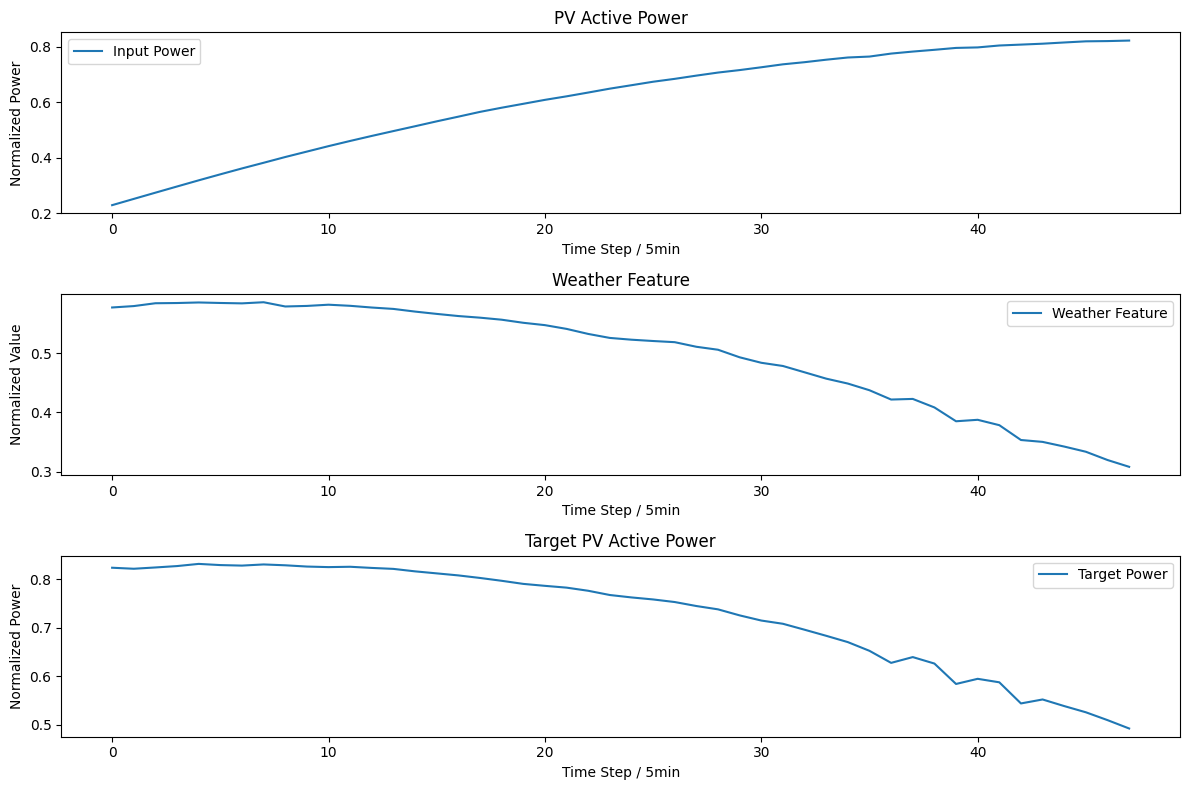

In [ ]:
#定义数据集
class PVData(Dataset):
    def __init__(self, power,weather,input_len,output_len,step=48):
        self.power = power
        self.weather = weather
        self.input_len=input_len
        self.output_len=output_len
        self.step=step 
    
    def __len__(self):
        return (len(self.power)-self.input_len-self.output_len)//self.step+1 #计算样本数
    def __getitem__(self, index): #此处的index根据计算的样本数进行迭代，从0到样本数-1
        power_start=index*self.step
        power_end=power_start+self.input_len

        weather_start=power_end
        weather_end=weather_start+self.output_len

        target_start=power_end
        target_end=target_start+self.output_len

        power_seq=self.power[power_start:power_end]
        weather_seq=self.weather[weather_start:weather_end]
        target_seq=self.power[target_start:target_end]

        return torch.Tensor(power_seq),torch.Tensor(weather_seq),torch.Tensor(target_seq)
    
#划分数据集
train_ratio,val_ratio,test_ratio=0.7,0.1,0.2
data_len=len(df_power)
train_len=int(data_len*train_ratio)
val_len=int(data_len*val_ratio)
test_len=data_len-train_len-val_len

#训练集
power_train=df_power[:train_len]
weather_train=df_weather[:train_len]
#验证集
power_val=df_power[train_len:train_len+val_len]
weather_val=df_weather[train_len:train_len+val_len]
#测试集
power_test=df_power[train_len+val_len:]
weather_test=df_weather[train_len+val_len:]

#分别对气象数据和功率数据进行归一化
weather_scaler=MinMaxScaler()
power_scaler=MinMaxScaler()
#对训练集进行归一化
weather_train=weather_scaler.fit_transform(weather_train)
power_train=power_scaler.fit_transform(power_train)
#使用训练集参数对验证集和测试集归一化⭐⭐⭐
weather_val=weather_scaler.transform(weather_val)
weather_test=weather_scaler.transform(weather_test)
power_val=power_scaler.transform(power_val)
power_test=power_scaler.transform(power_test)

#设置批次大小，并创建数据加载器
batch_size=32
input_len=48 #输入数据长度
output_len=48 #输出数据长度
step=48 #样本间的不重复时间步长
input_channel=2 #输入数据通道数
output_channel=1 #输出数据通道数
train_dataset=PVData(power_train,weather_train,input_len,output_len,step)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataset=PVData(power_val,weather_val,input_len,output_len,step)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataset=PVData(power_test,weather_test,input_len,output_len,step)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#测试数据加载器是否正常
#获取一个批次的数据
for power_seq,weather_seq,target_seq in train_loader:
    print(power_seq.shape,weather_seq.shape,target_seq.shape)
    #绘制三个子图
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    # 绘制输入有功功率子图
    axs[0].plot(power_seq[0, :, 0], label='Input Power')
    axs[0].set_title('PV Active Power')
    axs[0].set_xlabel('Time Step / 5min')
    axs[0].set_ylabel('Normalized Power')
    axs[0].legend()
    # 绘制天气子图
    axs[1].plot(weather_seq[0, :, 0], label='Weather Feature')
    axs[1].set_title('Weather Feature')
    axs[1].set_xlabel('Time Step / 5min')
    axs[1].set_ylabel('Normalized Value')
    axs[1].legend()
    # 绘制目标光伏有功功率子图
    axs[2].plot(target_seq[0, :, 0], label='Target Power')
    axs[2].set_title('Target PV Active Power')
    axs[2].set_xlabel('Time Step / 5min')
    axs[2].set_ylabel('Normalized Power')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    break

## 3 测试朴素预测模型效果（朴素预测模型无需训练）

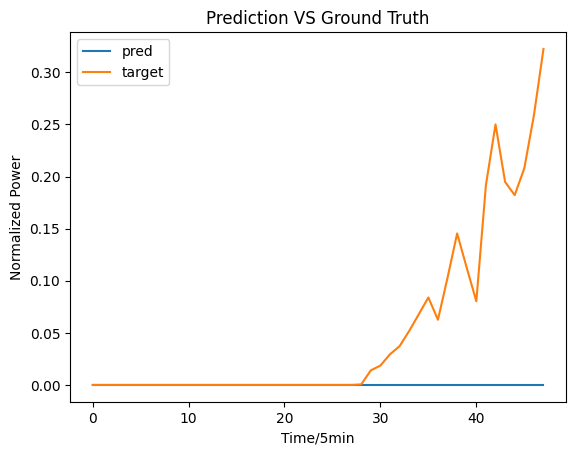

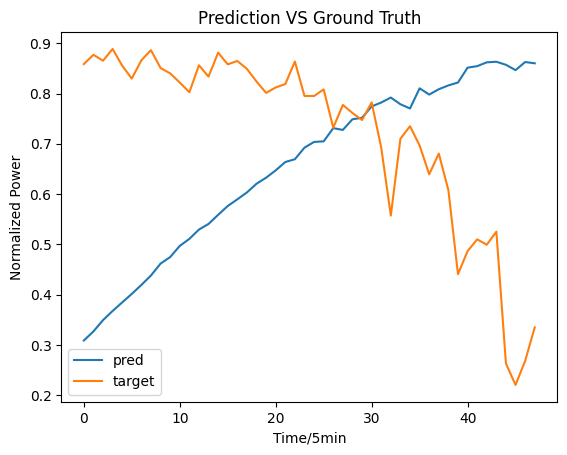

朴素预测模型的预测精度如下：
RMSE: 0.367551
MAE: 0.251076
R2 : -0.358162


In [ ]:
#测试朴素预测模型的预测精度
all_pred_seq=[]
all_target_seq=[]
for i,(power_seq,weather_seq,target_seq) in enumerate(test_loader):
    #设置设备
    power_seq=power_seq.to(device)
    weather_seq=weather_seq.to(device)
    target_seq=target_seq.to(device)
    #将过去4小时的光伏有功功率作为预测值
    pred_seq=power_seq[:,-output_len:,:] #仅适用于输入长度大于输出长度的情况⭐⭐⭐
    #保存结果到CPU
    all_pred_seq.append(pred_seq.detach().cpu())
    all_target_seq.append(target_seq.detach().cpu())
    if i % 10 ==0:
        plt.plot(pred_seq[0,:,0].cpu().numpy(),label='pred')
        plt.plot(target_seq[0,:,0].cpu().numpy(),label='target')
        plt.title('Prediction VS Ground Truth')
        plt.xlabel('Time/5min')
        plt.ylabel('Normalized Power')
        plt.legend()
        plt.show()

#拼接所有batch
all_pred_seq=torch.cat(all_pred_seq,dim=0) # 形状为(B,L,C)
all_target_seq=torch.cat(all_target_seq,dim=0) # 形状为(B,L,C)

# 去掉特征维 (B, L, 1) -> (B, L)
pred = all_pred_seq.squeeze(-1)
target = all_target_seq.squeeze(-1)

# 展平为一维 (B * L)
pred_np = pred.numpy().reshape(-1)
target_np = target.numpy().reshape(-1)

# === 指标计算 ===
rmse = np.sqrt(mean_squared_error(target_np, pred_np))
mae = mean_absolute_error(target_np, pred_np)
r2 = r2_score(target_np, pred_np)

print('朴素预测模型的预测精度如下：')
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 : {r2:.6f}")

## 4.1 构建线性回归模型

In [ ]:
#定义线性回归模型⭐⭐⭐⭐⭐
class LinearRegression(nn.Module):
    def __init__(self,input_len,input_channel,output_len,output_channel):
        super().__init__()
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_len=input_len
        self.input_channel=input_channel
        self.linear = nn.Linear(self.input_dim, self.output_dim) #线性回归层(默认包含偏置)
    def forward(self,x):
        #将（B，L，C）转换为（B，L*C）
        x=x.reshape(-1,self.input_dim)
        #线性变换
        x=self.linear(x)
        #将（B，L*C）转换为（B，L，C）
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x
    
#设置模型保存目录
save_path="model_weight"
os.makedirs(save_path,exist_ok=True) #创建模型保存目录(如果没有目录的话)
#设置三类正则化策略，Norm表示无正则化，Ridge表示L2正则化，Lasso表示L1正则化
reg_types=["Norm","Ridge","Lasso"]
#定义损失函数
criterion=nn.MSELoss()
#初始化三种线性回归模型（此处三种线性回归模型是一致的，只是训练时的正则化有所区别）
model_list=[]
model_name_list=[]
optimizer_list=[]
for reg_type in reg_types:
    model_name=f"LinearRegression_{reg_type}"
    model_name_list.append(model_name)
    model=LinearRegression(input_len,input_channel,output_len,output_channel)
    model.to(device)
    model_list.append(model)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
    optimizer_list.append(optimizer)


## 4.2 训练三种线性回归模型

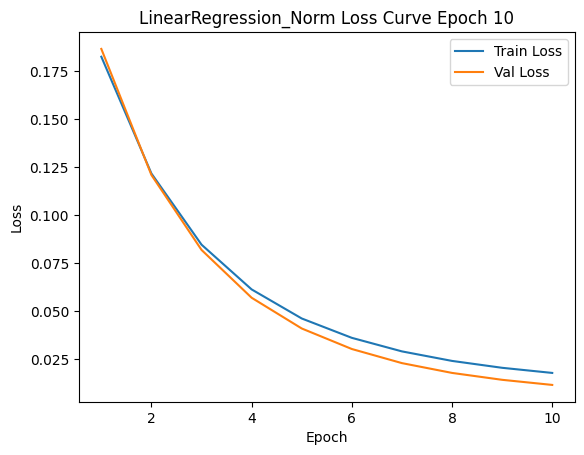

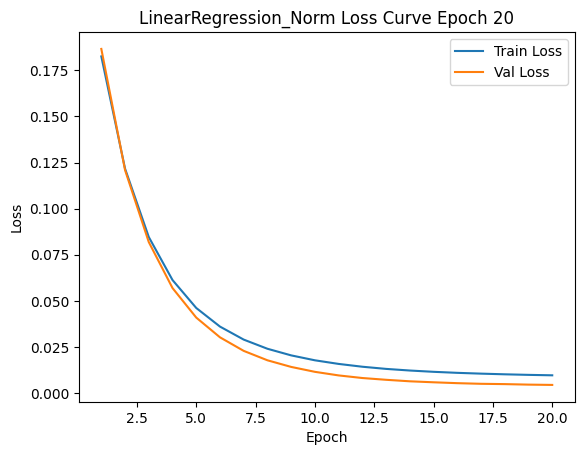

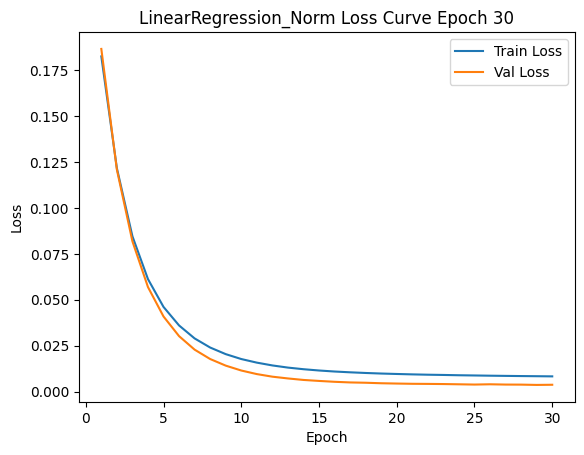

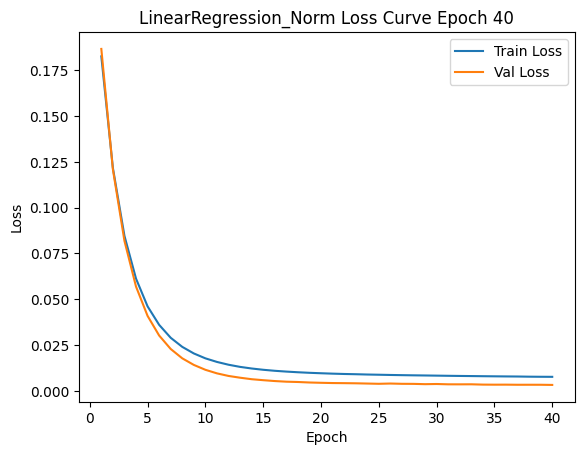

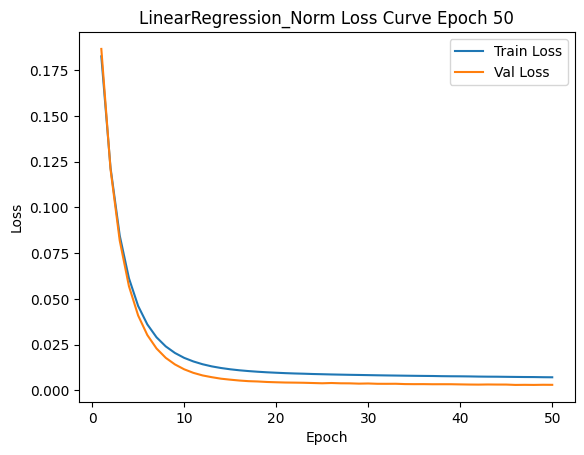

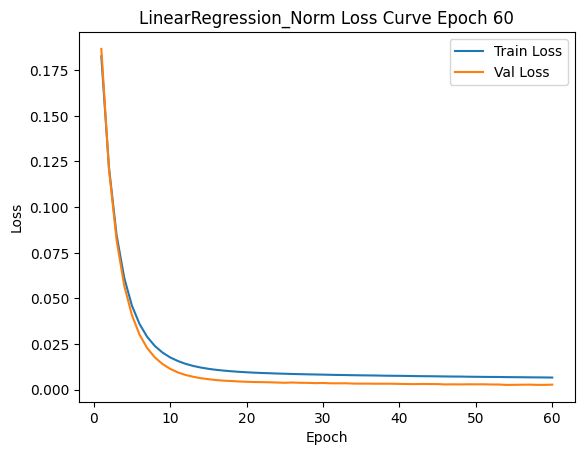

早停法触发，第64轮
LinearRegression_Norm训练时间: 5.19 秒
LinearRegression_Norm整个训练过程的损失曲线图


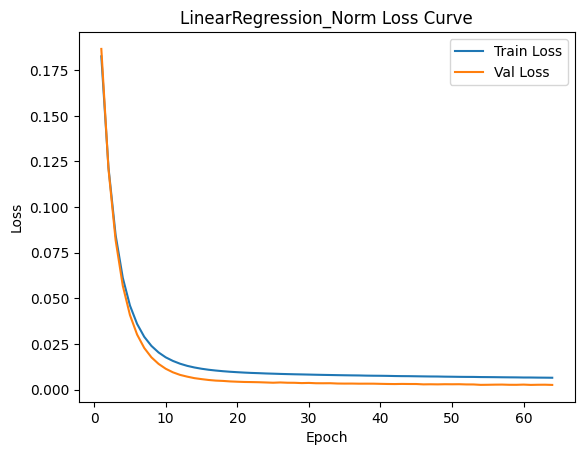

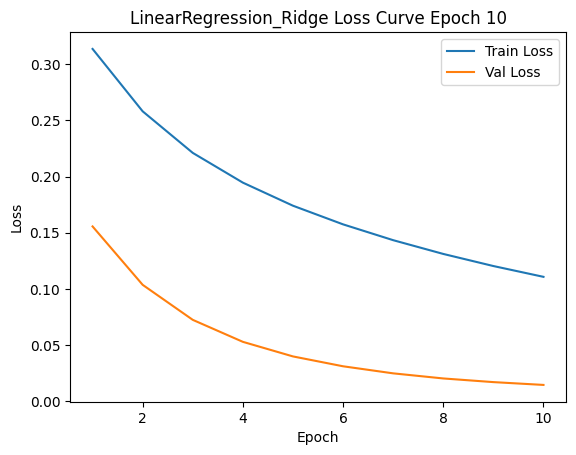

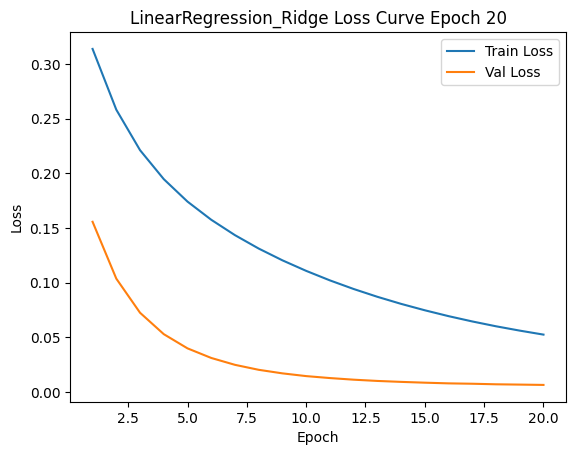

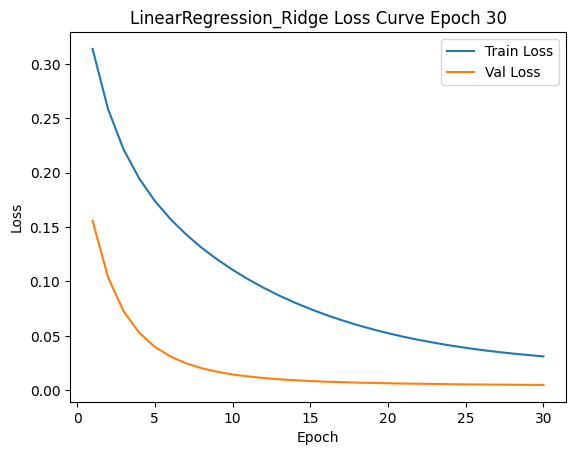

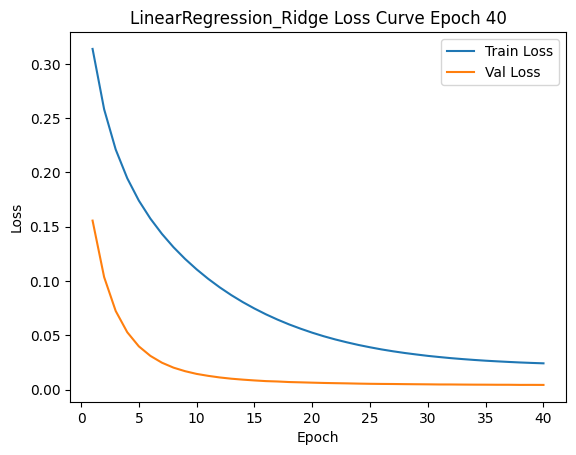

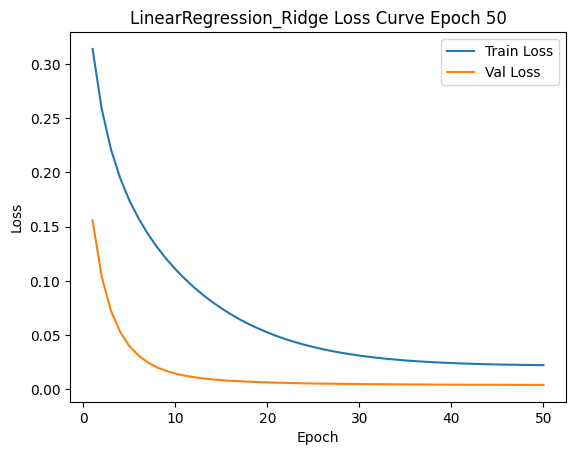

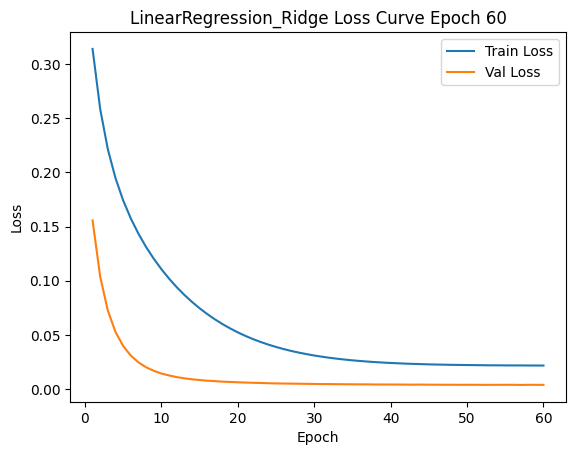

早停法触发，第67轮
LinearRegression_Ridge训练时间: 5.95 秒
LinearRegression_Ridge整个训练过程的损失曲线图


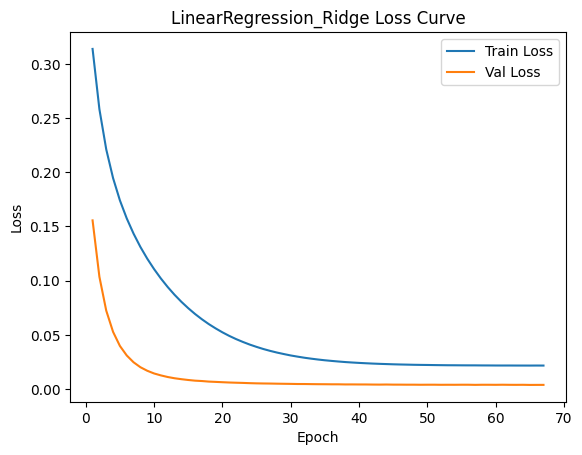

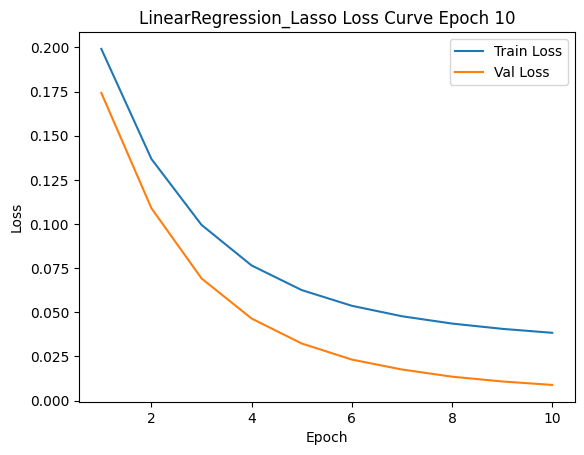

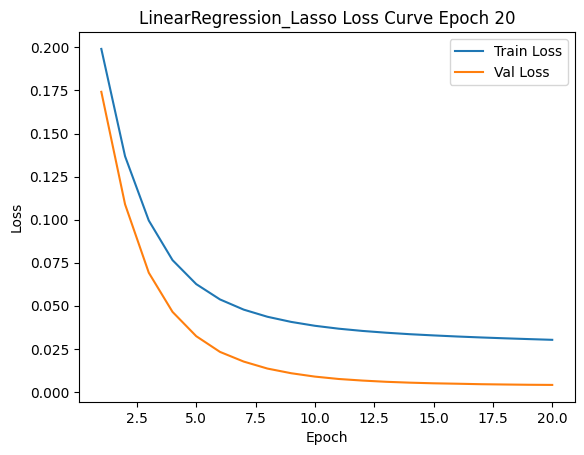

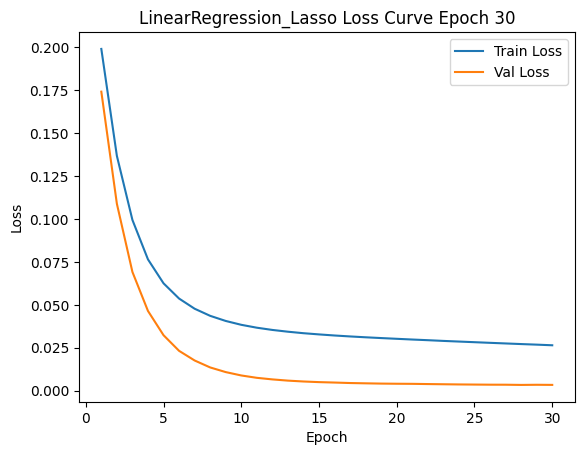

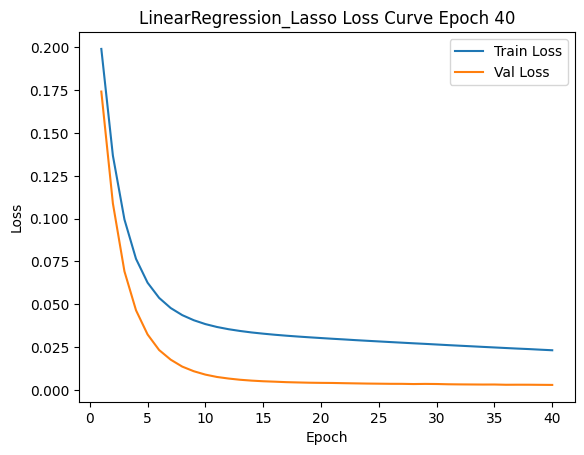

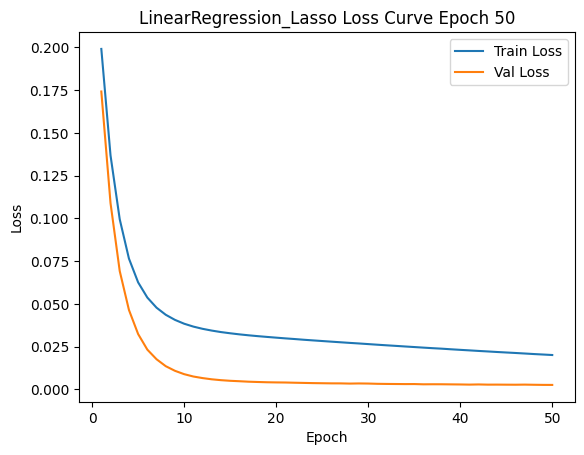

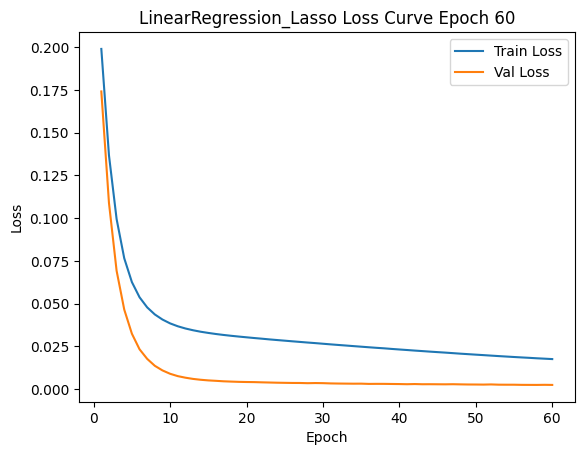

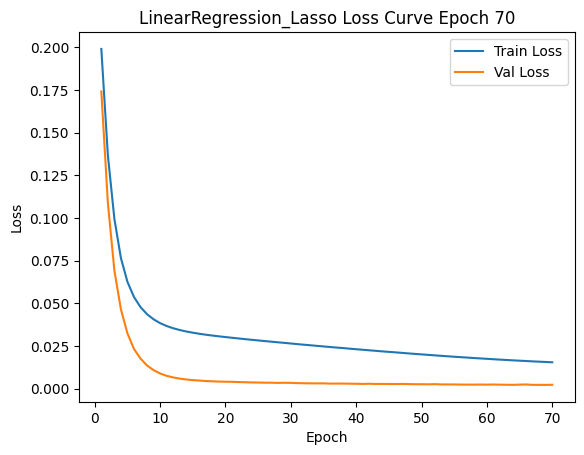

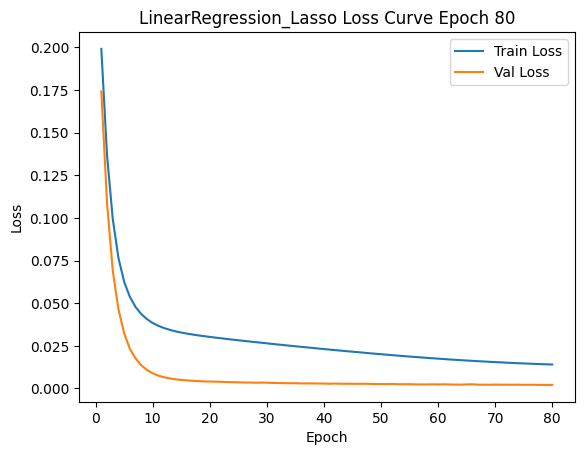

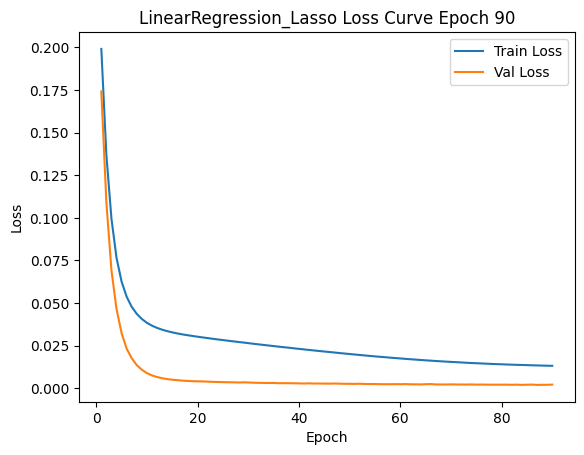

早停法触发，第92轮
LinearRegression_Lasso训练时间: 8.48 秒
LinearRegression_Lasso整个训练过程的损失曲线图


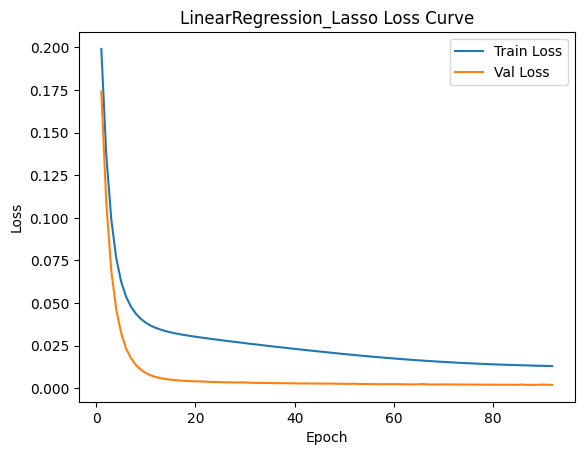

In [ ]:
#设置模型训练超参数
epochs=300
patience=10
delta=0.0001
lambda_ridge = 0.01  # L2 正则化强度
lambda_lasso = 0.0001  # L1 正则化强度(因为L1正则化可能导致权重为0，产生欠拟合，所有强度低于L2)⭐⭐⭐

def train(model,optimizer,model_name,criterion,reg_type='Norm'):
    """
    model:模型
    optimizer:优化器
    model_name:模型名称
    criterion:损失函数
    reg_type:正则化，包括"Norm","Ridge","Lasso"
    """
    start_time=time.time()
    best_loss=float('inf')
    early_stop_count=0
    train_losses=[]
    val_losses=[]
    for epoch in range(1,epochs+1):
        model.train()
        train_loss=0
        for power_seq,weather_seq,target_seq in train_loader:
            power_seq=power_seq.to(device)
            weather_seq=weather_seq.to(device)
            target_seq=target_seq.to(device)

            #在特征维度拼接光伏功率数据和气象数据
            input_seq=torch.cat((power_seq,weather_seq),dim=2)
            #前向传播⭐
            output_seq=model(input_seq)
            #计算损失⭐
            loss=criterion(output_seq,target_seq)
            if reg_type == "Norm":
                pass

            elif reg_type == "Ridge":
                # L2 正则化⭐⭐⭐⭐⭐
                l2_reg=0
                for name,param in model.named_parameters():
                    if name.endswith("weight"):
                        l2_reg += torch.sum(param ** 2)
                loss += lambda_ridge * l2_reg

            elif reg_type == "Lasso":
                # L1 正则化⭐⭐⭐⭐⭐
                l1_reg=0
                for name,param in model.named_parameters():
                    if name.endswith("weight"):
                        l1_reg += torch.sum(torch.abs(param))
                loss += lambda_lasso * l1_reg

            #反向传播和优化⭐
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)#梯度剪枝,避免正则化导致梯度不稳定⭐
            optimizer.step() #更新模型参数⭐
            #保存损失
            train_loss+=loss.item()
        train_loss/=len(train_loader)
        train_losses.append(train_loss)
        
        #早停法
        model.eval() #评估和测试模型时，需要将模型切换到评估模式，避免模型在训练时的一些操作，如dropout⭐⭐⭐⭐⭐
        with torch.no_grad():
            val_loss=0
            for power_seq,weather_seq,target_seq in val_loader:
                power_seq=power_seq.to(device)
                weather_seq=weather_seq.to(device)
                target_seq=target_seq.to(device)
                #在特征维度拼接光伏功率数据和气象数据
                input_seq=torch.cat((power_seq,weather_seq),dim=2)
                #前向传播
                output_seq=model(input_seq)
                #计算损失
                loss=criterion(output_seq,target_seq)
                #保存损失
                val_loss+=loss.item()
            val_loss/=len(val_loader)
            val_losses.append(val_loss)

            #早停法判断
            if val_loss<best_loss-delta:
                best_loss=val_loss
                early_stop_count=0
                #保存最优模型
                model_path=os.path.join(save_path,f'{model_name}.pth')
                torch.save(model.state_dict(),model_path)
            else:
                early_stop_count+=1
                if early_stop_count>=patience:
                    print(f"早停法触发，第{epoch}轮")
                    break
        #间隔一定轮数就绘制损失曲线图
        if epoch % 10 == 0:
            #绘制训练损失曲线图
            plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
            plt.plot(range(1,epoch+1),val_losses,label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'{model_name} Loss Curve Epoch {epoch}')
            plt.legend()
            plt.show()
    #记录训练结束时间     
    end_time=time.time()
    training_time=end_time-start_time
    print(f"{model_name}训练时间: {training_time:.2f} 秒")

    #绘制整个训练过程的损失曲线图
    print(f"{model_name}整个训练过程的损失曲线图")
    plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
    plt.plot(range(1,epoch+1),val_losses,label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.show()
    print("="*50)

#训练三种线性回归模型
for model,optimizer,model_name,reg_type in zip(model_list,optimizer_list,model_name_list,reg_types):
    train(model,optimizer,model_name,criterion,reg_type)

## 4.3 测试三种线性回归模型

In [ ]:
def test(model,model_name):
    model.eval()
    all_pred_seq=[]
    all_target_seq=[]
    with torch.no_grad():
        for i,(power_seq,weather_seq,target_seq) in enumerate(test_loader):
            power_seq=power_seq.to(device)
            weather_seq=weather_seq.to(device)
            target_seq=target_seq.to(device)
            #拼接输入序列
            input_seq=torch.cat((power_seq,weather_seq),dim=2)
            #向前传播
            pred_seq=model(input_seq)
            #将预测序列和目标序列转移到CPU
            pred_seq=pred_seq.detach().cpu()
            target_seq=target_seq.detach().cpu()
            #将当前批次的预测序列和目标序列添加到列表中
            all_pred_seq.append(pred_seq)
            all_target_seq.append(target_seq)

        #拼接所有batch
        all_pred_seq=torch.cat(all_pred_seq,dim=0) # 形状为(B,L,C)
        all_target_seq=torch.cat(all_target_seq,dim=0) # 形状为(B,L,C)

        # 去掉特征维 (B, L, 1) -> (B, L)
        pred = all_pred_seq.squeeze(-1)
        target = all_target_seq.squeeze(-1)

        # 展平为一维 (B * L)
        pred_np = pred.numpy().reshape(-1)
        target_np = target.numpy().reshape(-1)

        # === 指标计算 ===
        rmse = np.sqrt(mean_squared_error(target_np, pred_np))
        mae = mean_absolute_error(target_np, pred_np)
        r2 = r2_score(target_np, pred_np)

        print("-"*50)
        print(f'{model_name}的预测精度如下：')
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"R2 : {r2:.6f}")
        print("-"*50)

#测试模型
for model,model_name in zip(model_list,model_name_list):
    #载入模型参数文件⭐
    model_path=os.path.join(save_path,f'{model_name}.pth')
    model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True))
    #测试模型
    test(model,model_name)


--------------------------------------------------
LinearRegression_Norm的预测精度如下：
RMSE: 0.100569
MAE: 0.066615
R2 : 0.898317
--------------------------------------------------
--------------------------------------------------
LinearRegression_Ridge的预测精度如下：
RMSE: 0.086590
MAE: 0.060053
R2 : 0.924621
--------------------------------------------------
--------------------------------------------------
LinearRegression_Lasso的预测精度如下：
RMSE: 0.089591
MAE: 0.057130
R2 : 0.919304
--------------------------------------------------


## 4.4 三种线性回归模型预测效果可视化

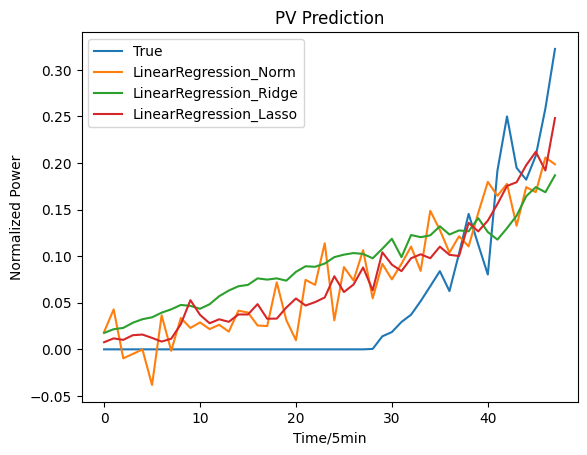

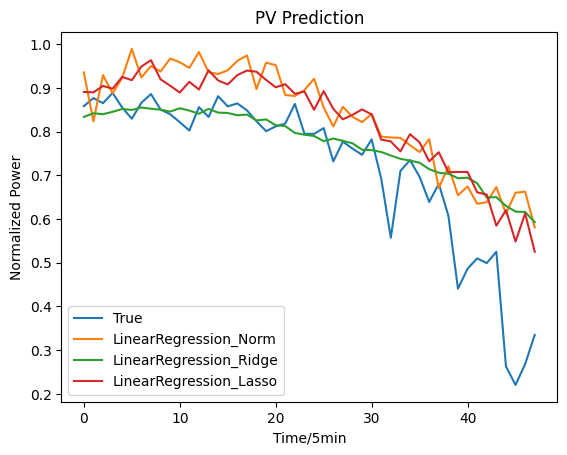

In [8]:
def show_pred_plot(model_list,model_name_list):
    for i,(power_seq,weather_seq,target_seq) in enumerate(test_loader):
        #转移到设备
        power_seq=power_seq.to(device)
        weather_seq=weather_seq.to(device)
        target_seq=target_seq.to(device)
        
        if i % 10 ==0:
            plt.plot(target_seq[0,:,0].cpu().numpy(),label='True')
            for model,model_name in zip(model_list,model_name_list):
                model.eval()
                with torch.no_grad():
                    #向前传播
                    input_seq=torch.cat((power_seq,weather_seq),dim=2)
                    pred_seq=model(input_seq)
                    #将预测序列转移到CPU
                    pred_seq=pred_seq.detach().cpu()
                    plt.plot(pred_seq[0,:,0].numpy(),label=model_name)
            plt.xlabel('Time/5min')
            plt.ylabel('Normalized Power')
            plt.title('PV Prediction')
            plt.legend()
            plt.show()

#可视化三种线性回归模型的预测效果
show_pred_plot(model_list,model_name_list)

## 5.1 构建多层感知机MLP模型

In [ ]:
#定义Sigmoid激活函数的MLP(不包含层归一化)
class MLP_Sigmoid(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.activation=nn.Sigmoid() #激活函数为Sigmoid⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x

#定义Sigmoid激活函数的MLP(包含层归一化)
class MLP_Sigmoid_Norm(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.activation=nn.Sigmoid() #激活函数为Sigmoid⭐
        self.norm1=nn.LayerNorm(self.hidden_dim) #层归一化⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.norm2=nn.LayerNorm(self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.norm1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.norm2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x
        
#定义ReLU激活函数的MLP(不包含层归一化)
class MLP_ReLU(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.activation=nn.ReLU() #激活函数为ReLU⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x

#定义ReLU激活函数的MLP(包含层归一化)
class MLP_ReLU_Norm(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.norm1=nn.LayerNorm(self.hidden_dim) #层归一化⭐
        self.activation=nn.ReLU() #激活函数为ReLU⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.norm2=nn.LayerNorm(self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.norm1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.norm2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x
    
#定义Tanh激活函数的MLP(不包含层归一化)
class MLP_Tanh(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.activation=nn.Tanh() #激活函数为Tanh⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x

#定义Tanh激活函数的MLP(包含层归一化)
class MLP_Tanh_Norm(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.norm1=nn.LayerNorm(self.hidden_dim) #层归一化⭐
        self.activation=nn.Tanh() #激活函数为Tanh⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.norm2=nn.LayerNorm(self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.norm1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.norm2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x

#定义LeakyReLU激活函数的MLP(不包含层归一化)
class MLP_LeakyReLU(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.activation=nn.LeakyReLU(negative_slope=0.01) #激活函数为LeakyReLU⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x
    
#定义LeakyReLU激活函数的MLP(包含层归一化)
class MLP_LeakyReLU_Norm(nn.Module):
    def __init__(self,input_len,input_channel,hidden_dim,output_len,output_channel):
        super().__init__()
        self.input_len=input_len
        self.input_channel=input_channel
        self.hidden_dim=hidden_dim
        self.output_len=output_len
        self.output_channel=output_channel
        self.input_dim=input_len*input_channel
        self.output_dim=output_len*output_channel

        self.linear1=nn.Linear(self.input_dim,self.hidden_dim)
        self.norm1=nn.LayerNorm(self.hidden_dim) #层归一化⭐
        self.activation=nn.LeakyReLU(negative_slope=0.01) #激活函数为LeakyReLU⭐
        self.linear2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.norm2=nn.LayerNorm(self.hidden_dim)
        self.linear3=nn.Linear(self.hidden_dim,self.output_dim)
    
    def forward(self,x):
        x=x.reshape(-1,self.input_dim)
        x=self.linear1(x)
        x=self.norm1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.norm2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=x.reshape(-1,self.output_len,self.output_channel)
        return x

#初始化各个模型和Adam优化器
hidden_dim=128
lr=0.0001
criterion=nn.MSELoss()

mlp_tanh=MLP_Tanh(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_tanh=torch.optim.Adam(mlp_tanh.parameters(),lr=lr)

mlp_tanh_norm=MLP_Tanh_Norm(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_tanh_norm=torch.optim.Adam(mlp_tanh_norm.parameters(),lr=lr)

mlp_leakyrelu=MLP_LeakyReLU(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_leakyrelu=torch.optim.Adam(mlp_leakyrelu.parameters(),lr=lr)

mlp_leakyrelu_norm=MLP_LeakyReLU_Norm(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_leakyrelu_norm=torch.optim.Adam(mlp_leakyrelu_norm.parameters(),lr=lr)


mlp_sigmoid=MLP_Sigmoid(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_sigmoid=torch.optim.Adam(mlp_sigmoid.parameters(),lr=lr)

mlp_sigmoid_norm=MLP_Sigmoid_Norm(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_sigmoid_norm=torch.optim.Adam(mlp_sigmoid_norm.parameters(),lr=lr)


mlp_relu=MLP_ReLU(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_relu=torch.optim.Adam(mlp_relu.parameters(),lr=lr)

mlp_relu_norm=MLP_ReLU_Norm(input_len,input_channel,hidden_dim,output_len,output_channel)
optimizer_relu_norm=torch.optim.Adam(mlp_relu_norm.parameters(),lr=lr)

model_list=[mlp_tanh,mlp_tanh_norm,mlp_leakyrelu,mlp_leakyrelu_norm,mlp_sigmoid,mlp_sigmoid_norm,mlp_relu,mlp_relu_norm]
optimizer_list=[optimizer_tanh,optimizer_tanh_norm,optimizer_leakyrelu,optimizer_leakyrelu_norm,optimizer_sigmoid,optimizer_sigmoid_norm,optimizer_relu,optimizer_relu_norm]
model_name_list=['mlp_tanh','mlp_tanh_norm','mlp_leakyrelu','mlp_leakyrelu_norm','mlp_sigmoid','mlp_sigmoid_norm','mlp_relu','mlp_relu_norm']

for model in model_list:
    model.to(device)


## 5.2 训练多层感知机模型（复用线性回归模型处的训练函数）

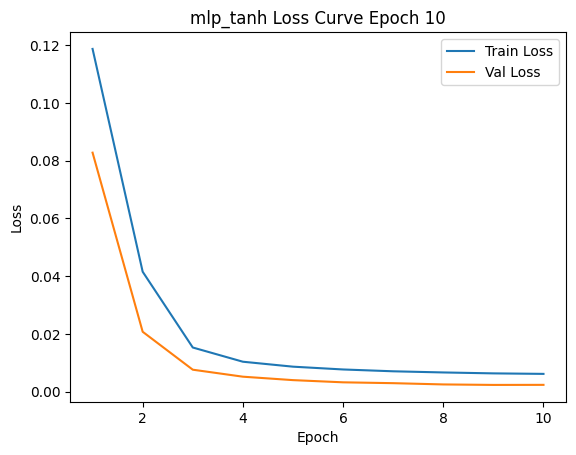

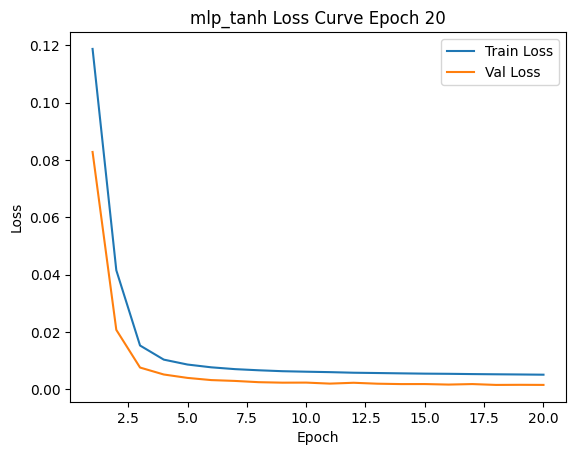

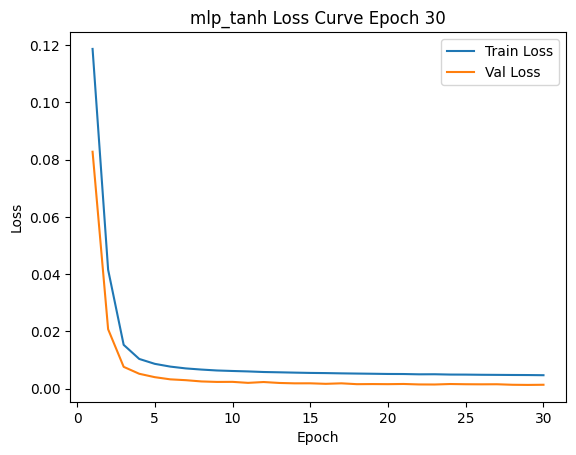

早停法触发，第39轮
mlp_tanh训练时间: 3.86 秒
mlp_tanh整个训练过程的损失曲线图


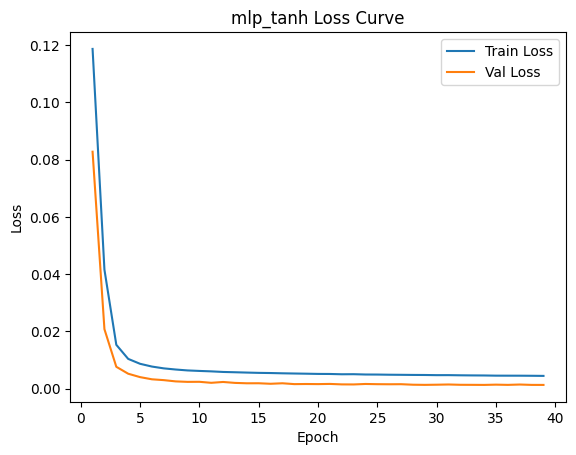

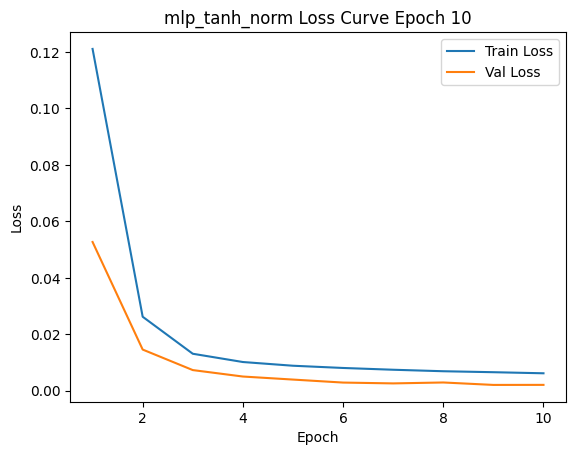

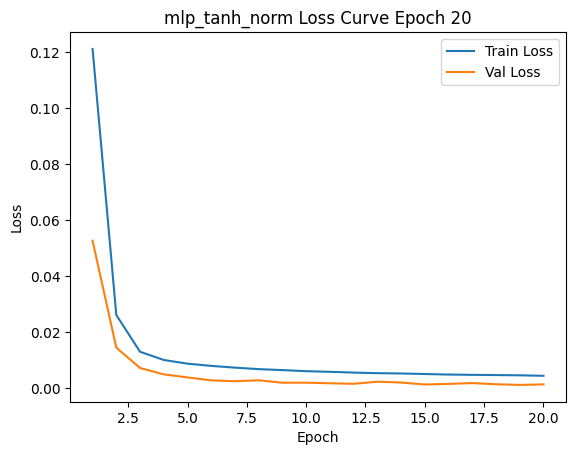

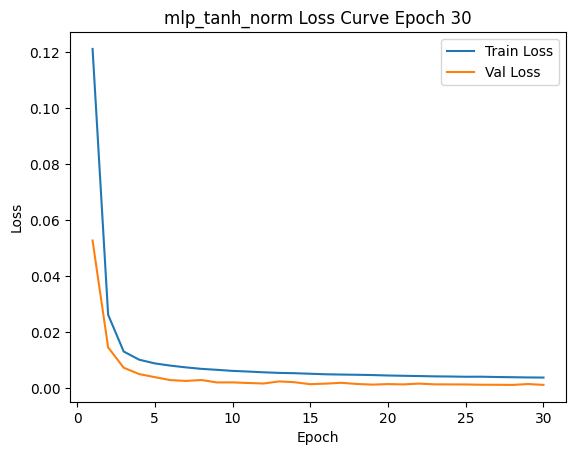

早停法触发，第38轮
mlp_tanh_norm训练时间: 3.99 秒
mlp_tanh_norm整个训练过程的损失曲线图


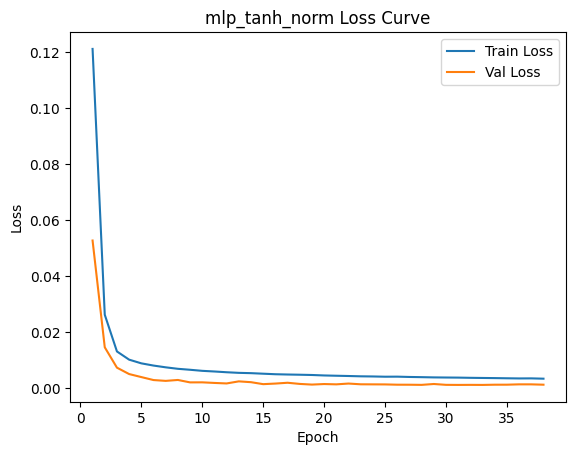

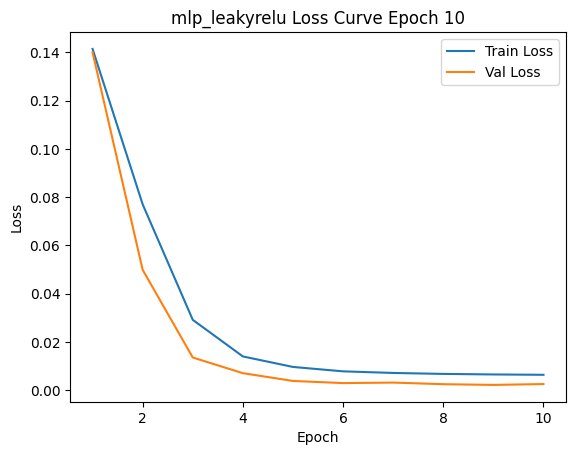

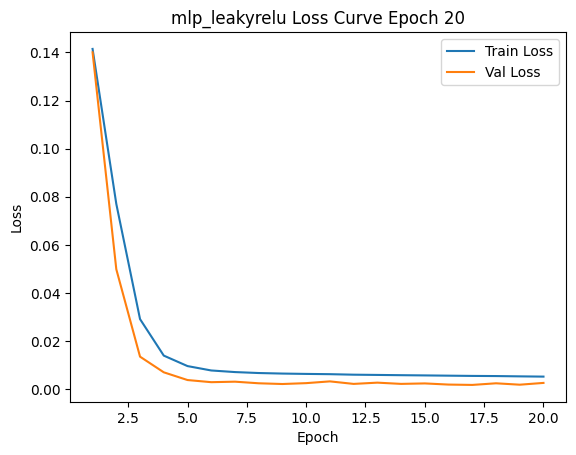

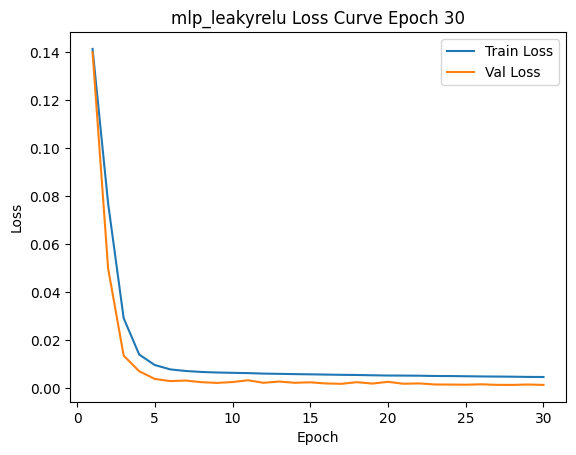

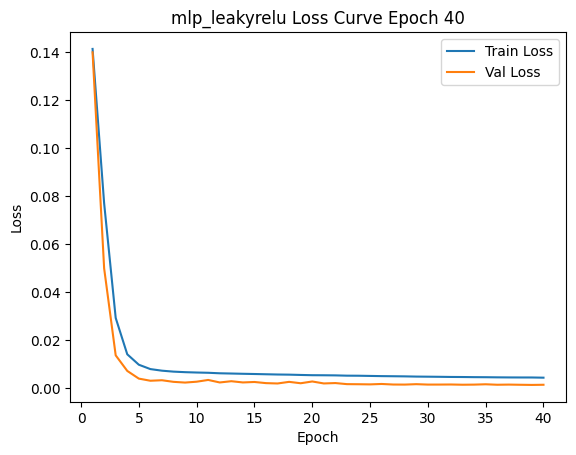

早停法触发，第43轮
mlp_leakyrelu训练时间: 4.74 秒
mlp_leakyrelu整个训练过程的损失曲线图


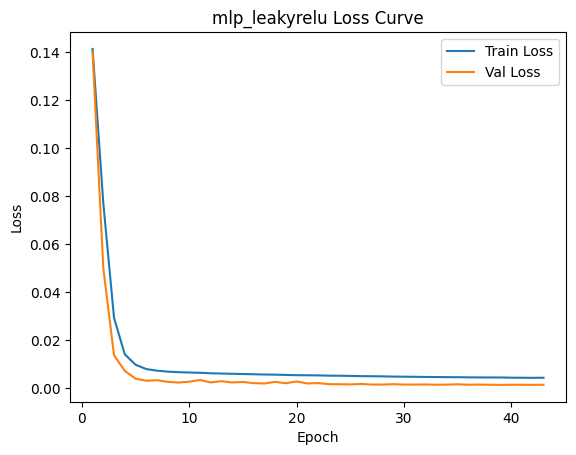

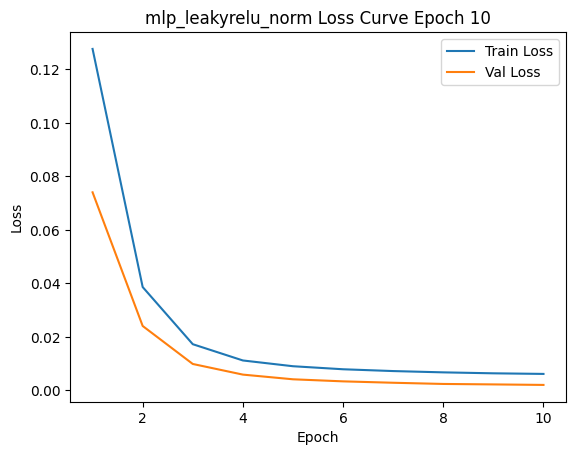

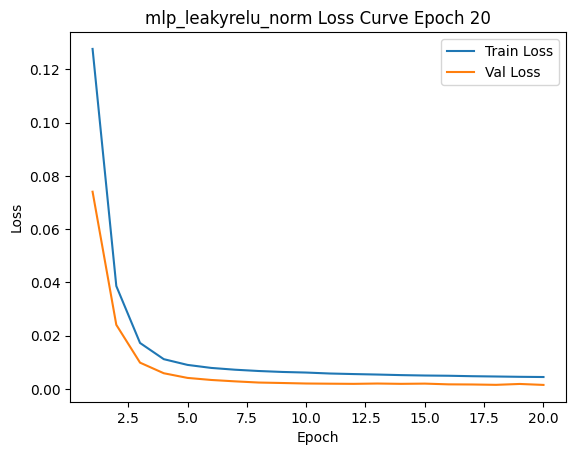

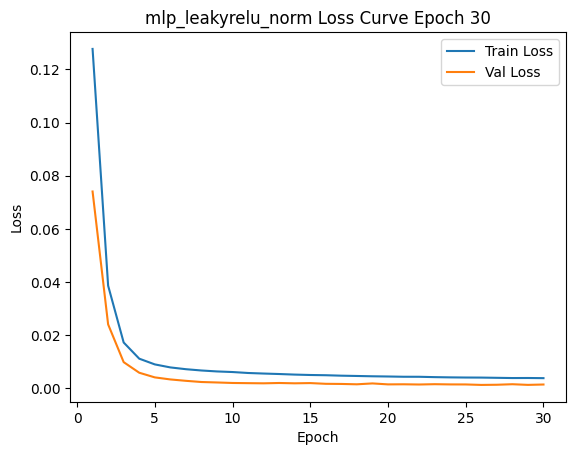

早停法触发，第36轮
mlp_leakyrelu_norm训练时间: 5.30 秒
mlp_leakyrelu_norm整个训练过程的损失曲线图


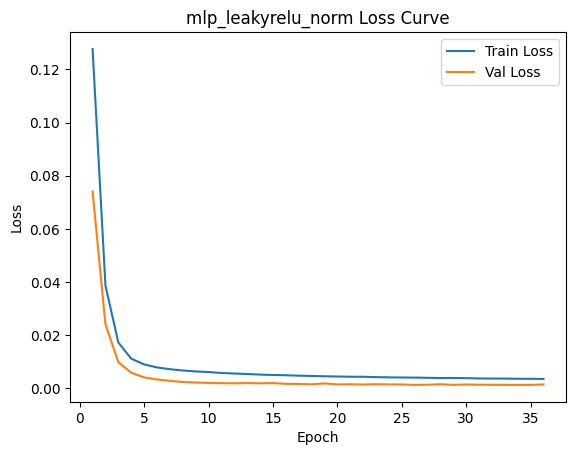

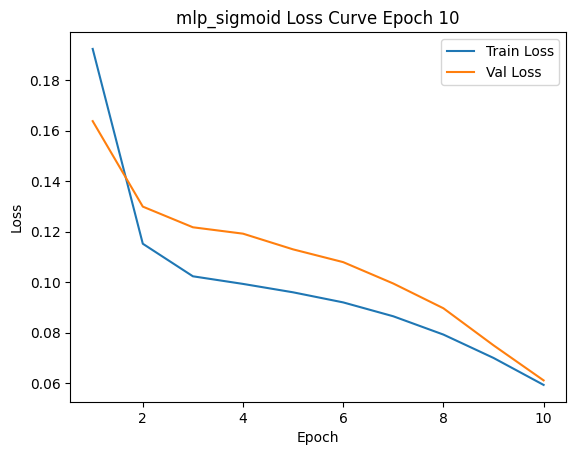

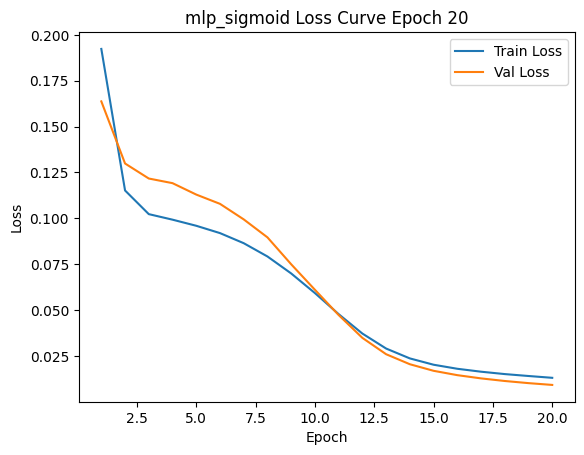

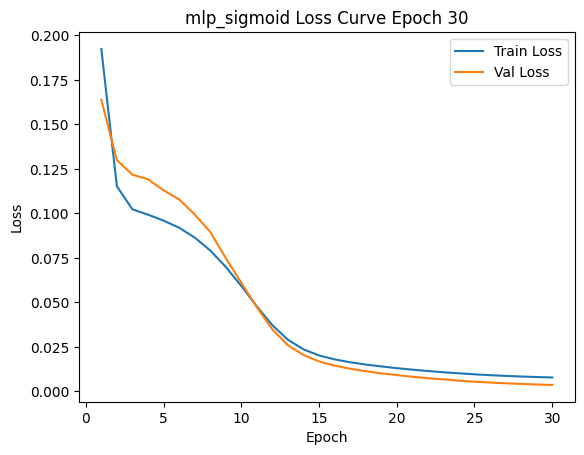

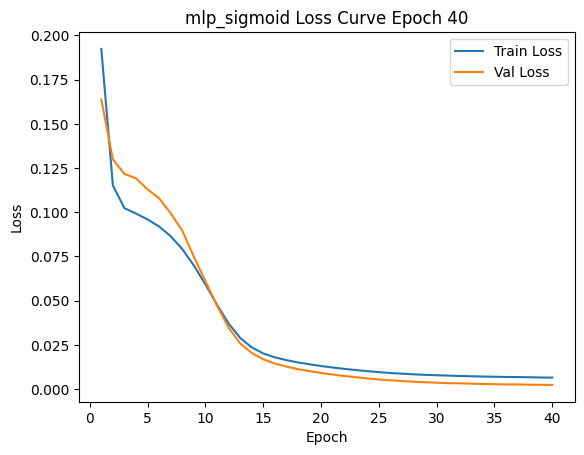

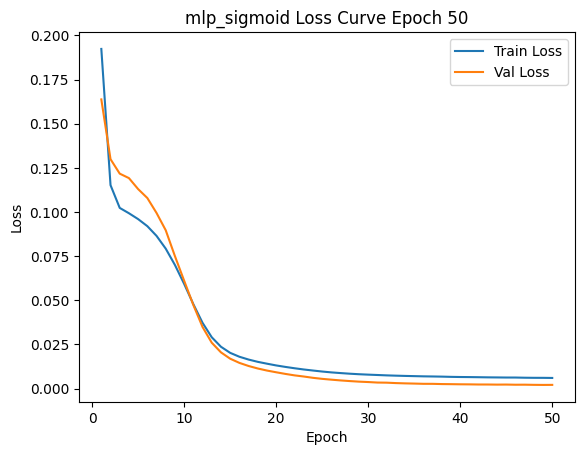

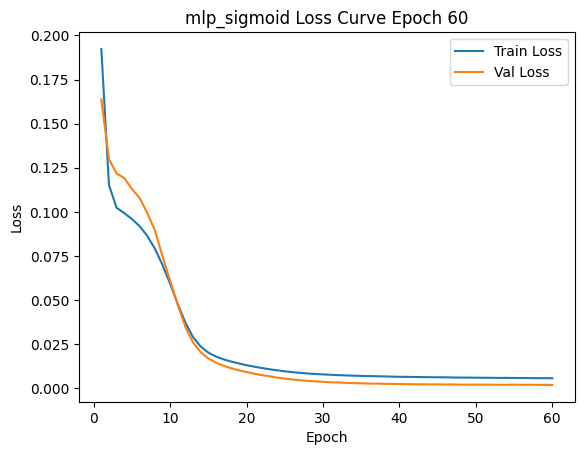

早停法触发，第68轮
mlp_sigmoid训练时间: 8.27 秒
mlp_sigmoid整个训练过程的损失曲线图


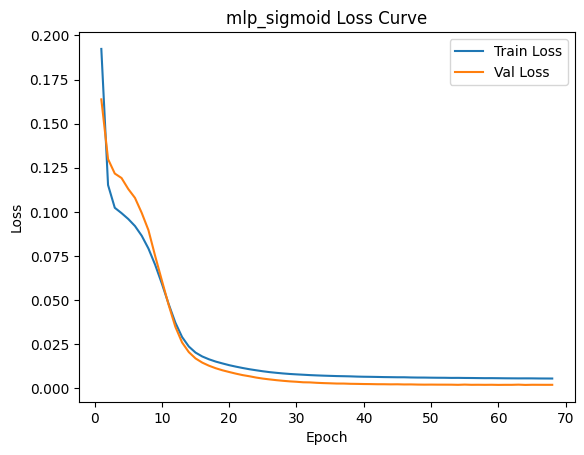

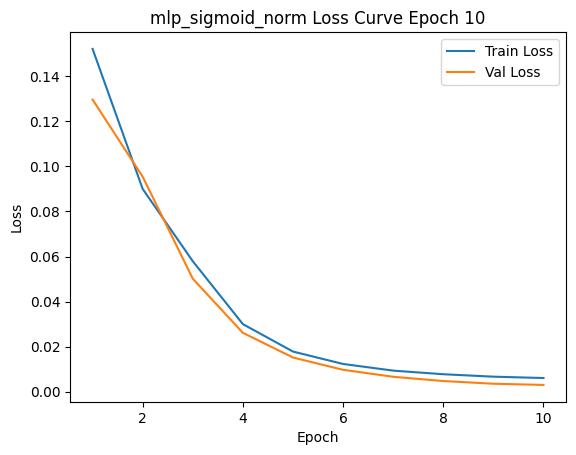

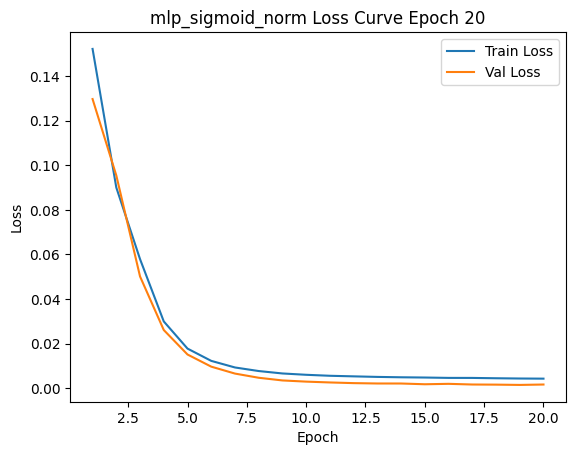

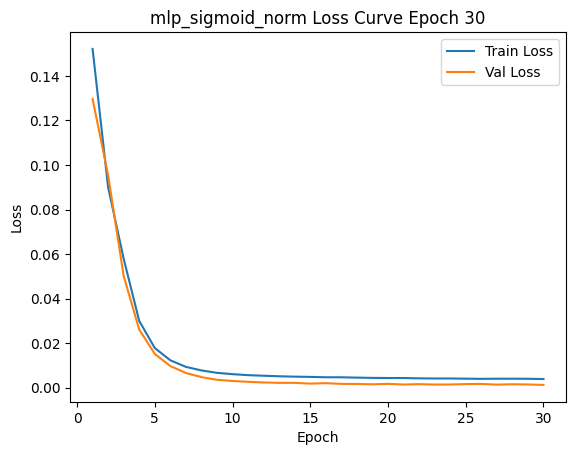

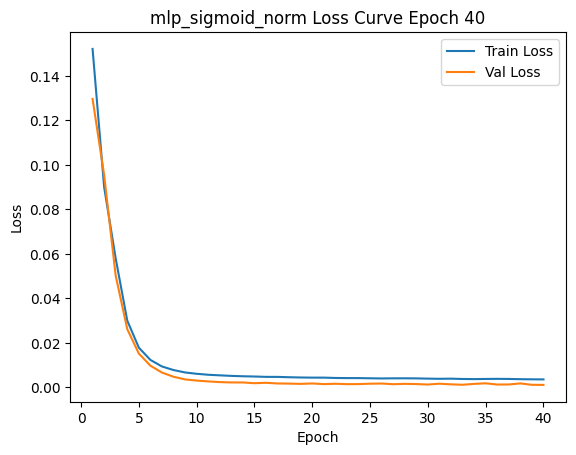

早停法触发，第43轮
mlp_sigmoid_norm训练时间: 5.67 秒
mlp_sigmoid_norm整个训练过程的损失曲线图


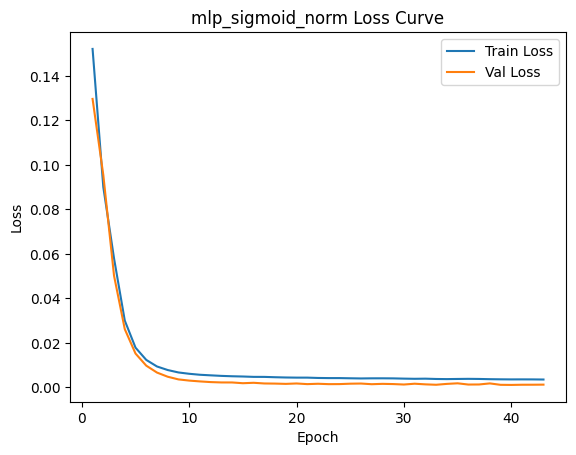

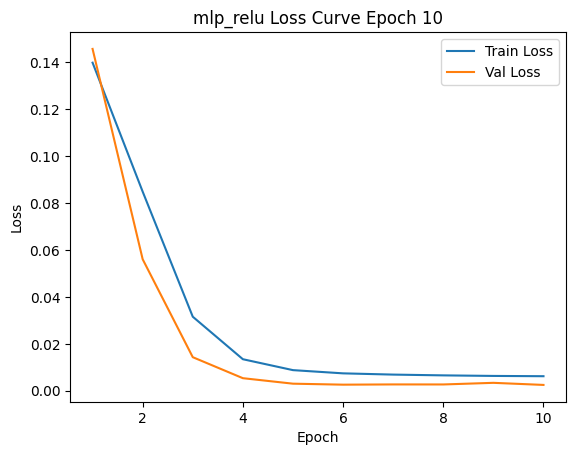

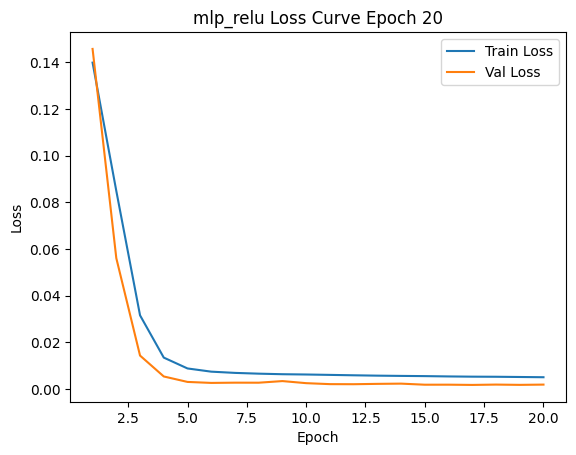

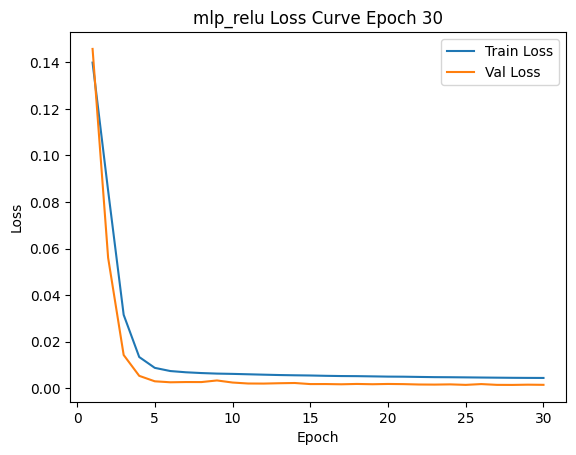

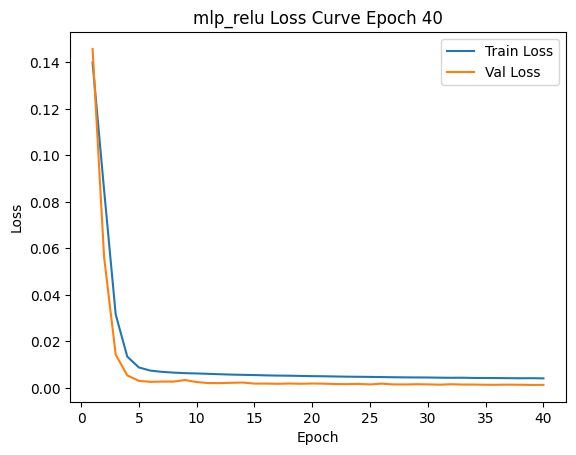

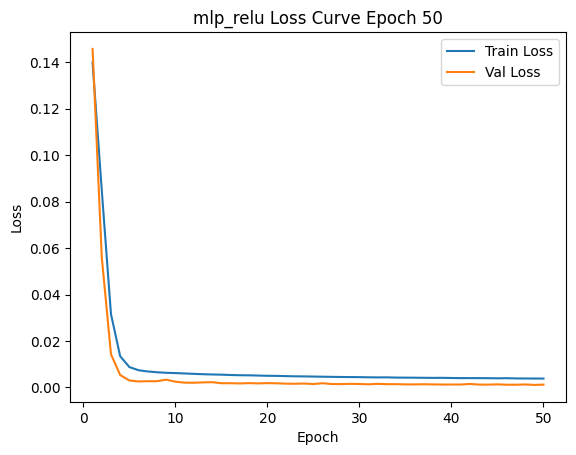

早停法触发，第59轮
mlp_relu训练时间: 7.23 秒
mlp_relu整个训练过程的损失曲线图


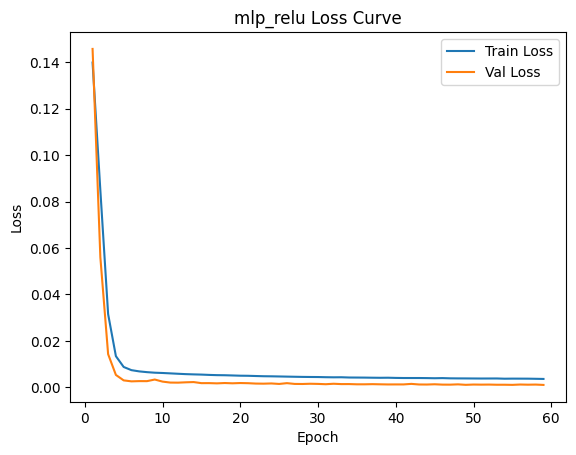

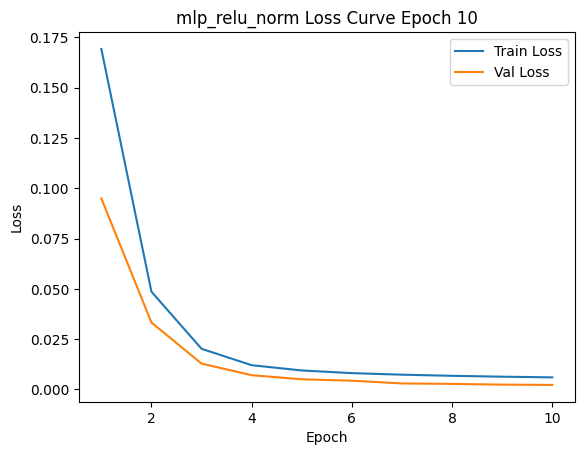

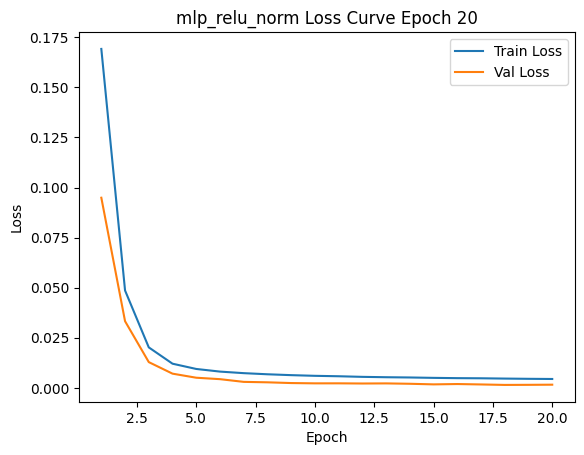

早停法触发，第28轮
mlp_relu_norm训练时间: 3.80 秒
mlp_relu_norm整个训练过程的损失曲线图


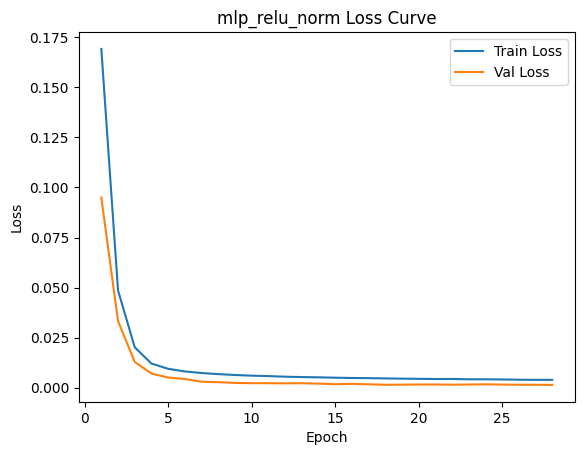

In [10]:
#设置模型训练超参数
epochs=300
patience=10
delta=0.0001

#训练模型
for model,optimizer,model_name in zip(model_list,optimizer_list,model_name_list):
    train(model,optimizer,model_name,criterion)

## 5.3 测试多层感知机模型（复用线性回归模型处的测试函数）

In [ ]:
#测试模型
for model,model_name in zip(model_list,model_name_list):
    #载入模型参数文件⭐
    model_path=os.path.join(save_path,f'{model_name}.pth')
    model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True))
    #测试模型
    test(model,model_name)

--------------------------------------------------
mlp_tanh的预测精度如下：
RMSE: 0.082111
MAE: 0.048589
R2 : 0.932217
--------------------------------------------------
--------------------------------------------------
mlp_tanh_norm的预测精度如下：
RMSE: 0.074826
MAE: 0.044050
R2 : 0.943711
--------------------------------------------------
--------------------------------------------------
mlp_leakyrelu的预测精度如下：
RMSE: 0.076919
MAE: 0.041894
R2 : 0.940519
--------------------------------------------------
--------------------------------------------------
mlp_leakyrelu_norm的预测精度如下：
RMSE: 0.080214
MAE: 0.045899
R2 : 0.935313
--------------------------------------------------
--------------------------------------------------
mlp_sigmoid的预测精度如下：
RMSE: 0.090404
MAE: 0.054695
R2 : 0.917834
--------------------------------------------------
--------------------------------------------------
mlp_sigmoid_norm的预测精度如下：
RMSE: 0.069836
MAE: 0.038770
R2 : 0.950968
------------------------------------------------

## 5.4 多种MLP模型预测结果可视化（复用线性回归模型处的可视化函数）

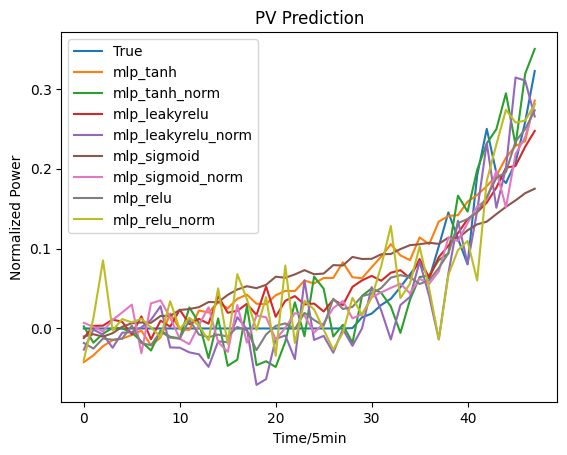

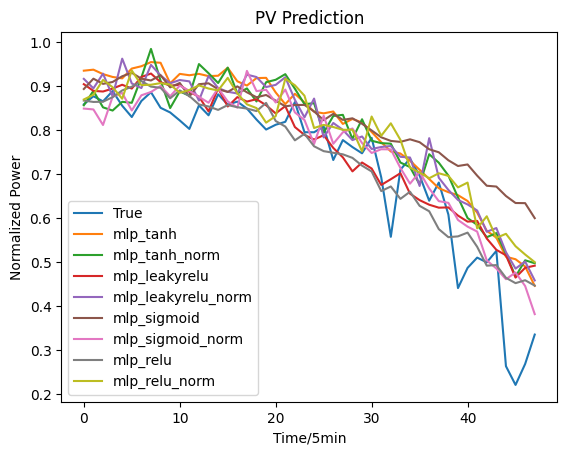

In [12]:
#可视化多种MLP模型的预测结果
show_pred_plot(model_list,model_name_list)

## 6.1 构建RNN和LSTM

In [ ]:
#构建LSTM⭐
class LSTM(nn.Module):
    """
    LSTM模型
    输入数据形状为(batch_size, input_len, input_channel)
    输出数据形状为(batch_size, output_len, output_channel)
    """
    def __init__(self, input_len,input_channel, hidden_size, num_layers, output_len,output_channel):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_len=input_len
        self.output_len=output_len
        self.lstm = nn.LSTM(input_channel, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_channel)
        self.len_adjust=nn.Linear(input_len,output_len)

    def forward(self, x):
        # 输入LSTM
        x, _ = self.lstm(x) #x的形状为(batch_size, input_len, hidden_size)，self.lstm(x)返回的是输出值和隐藏状态，此处不需要隐藏状态⭐⭐⭐
        # 输出LSTM
        x = self.fc(x) #x的形状为(batch_size, input_len, output_channel)
        # 调整输出长度
        if self.input_len!=self.output_len:
            x=self.len_adjust(x.permute(0,2,1)).permute(0,2,1) #x的形状为(batch_size, output_len, output_channel)
        return x
    
#构建RNN模型⭐
class RNN(nn.Module):
    """
    RNN模型
    输入数据形状为(batch_size, input_len, input_channel)
    输出数据形状为(batch_size, output_len, output_channel)
    """
    def __init__(self, input_len,input_channel, hidden_size, num_layers, output_len,output_channel):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_len=input_len
        self.output_len=output_len
        self.rnn = nn.RNN(input_channel, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_channel)
        self.len_adjust=nn.Linear(input_len,output_len)

    def forward(self, x):
        # 输入RNN
        x, _ = self.rnn(x) #x的形状为(batch_size, input_len, hidden_size),self.rnn(x)返回的是输出值和隐藏状态，此处不需要隐藏状态⭐⭐⭐
        # 输出RNN
        x = self.fc(x) #x的形状为(batch_size, input_len, output_channel)
        # 调整输出长度
        if self.input_len!=self.output_len:
            x=self.len_adjust(x.permute(0,2,1)).permute(0,2,1) #x的形状为(batch_size, output_len, output_channel)
        return x
    
#初始化模型和优化器
hidden_dim=128
lr=0.0001
criterion=nn.MSELoss()

lstm=LSTM(
    input_len=input_len,input_channel=input_channel,hidden_size=hidden_dim,
    num_layers=2,output_len=output_len,output_channel=output_channel)
optimizer_lstm=torch.optim.Adam(lstm.parameters(),lr=lr)

rnn=RNN(
    input_len=input_len,input_channel=input_channel,hidden_size=hidden_dim,
    num_layers=2,output_len=output_len,output_channel=output_channel)
optimizer_rnn=torch.optim.Adam(rnn.parameters(),lr=lr)

model_list=[lstm,rnn]
model_name_list=['LSTM','RNN']
optimizer_list=[optimizer_lstm,optimizer_rnn]

for model in model_list:
    model.to(device)

## 6.2 训练RNN和LSTM（复用线性回归模型处的训练函数）

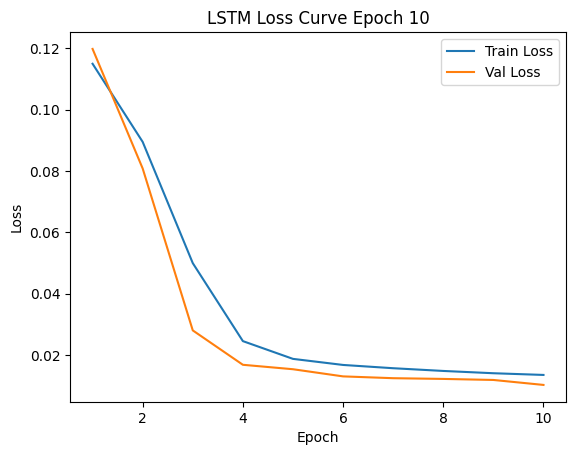

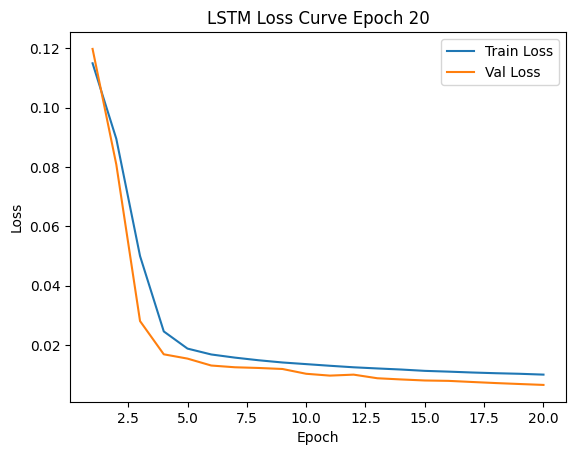

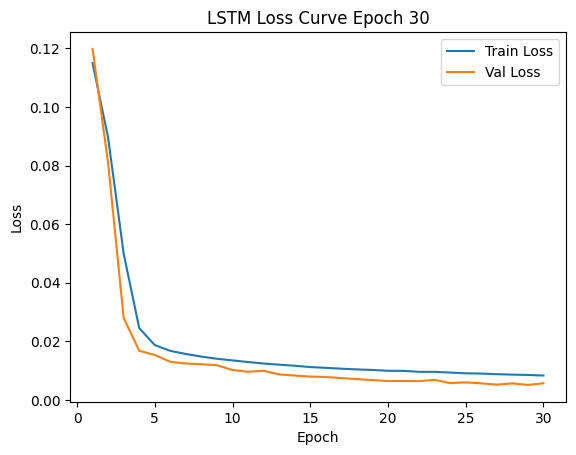

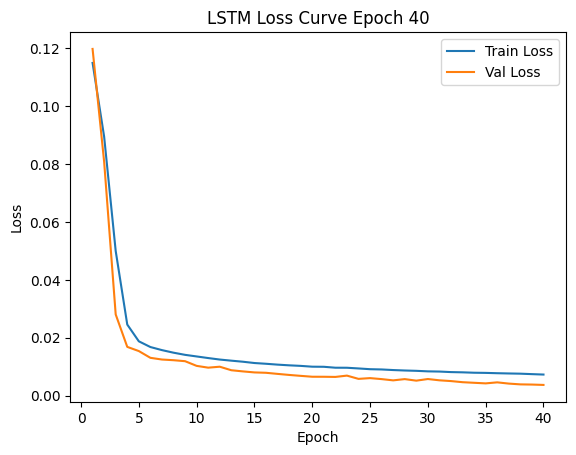

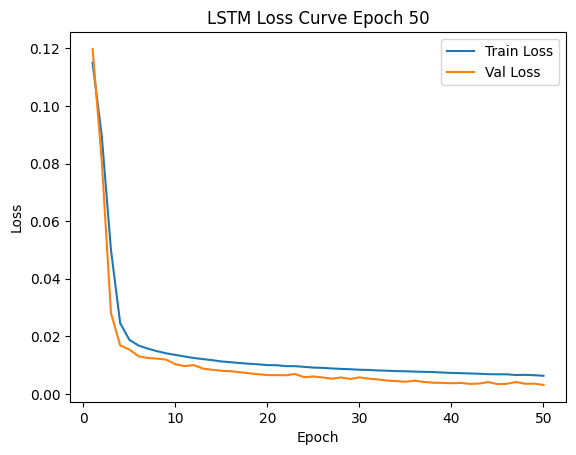

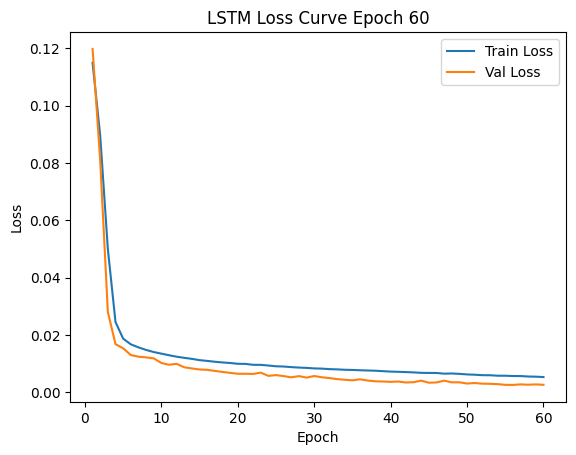

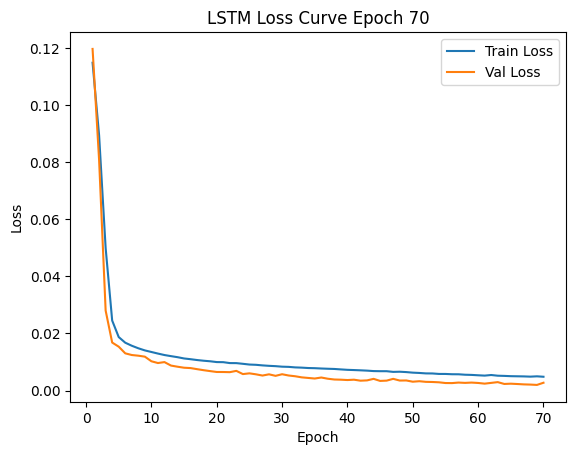

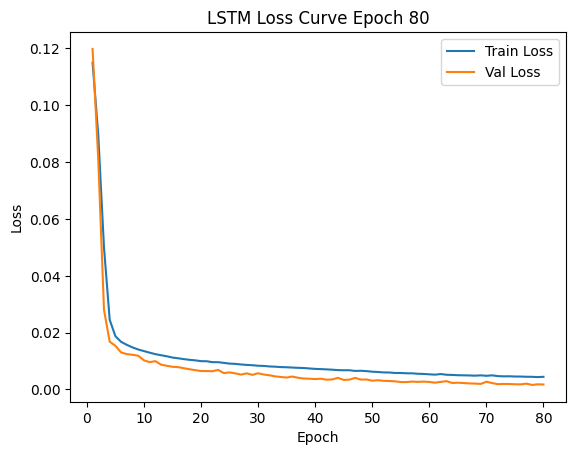

早停法触发，第88轮
LSTM训练时间: 12.80 秒
LSTM整个训练过程的损失曲线图


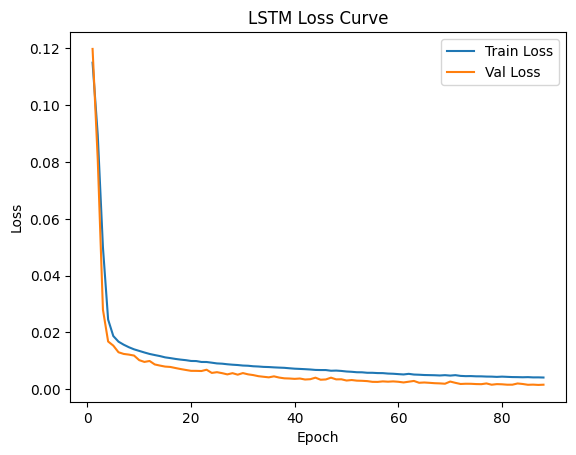

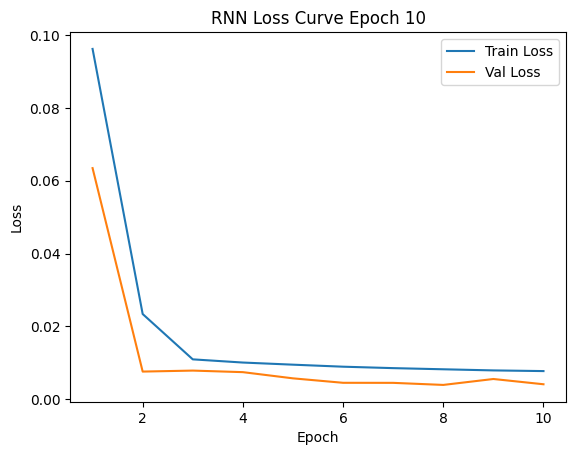

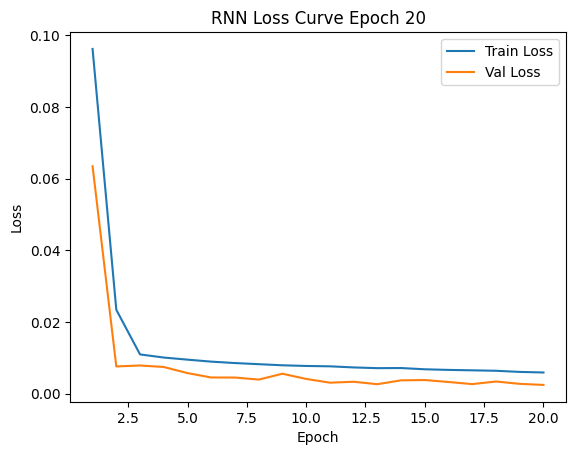

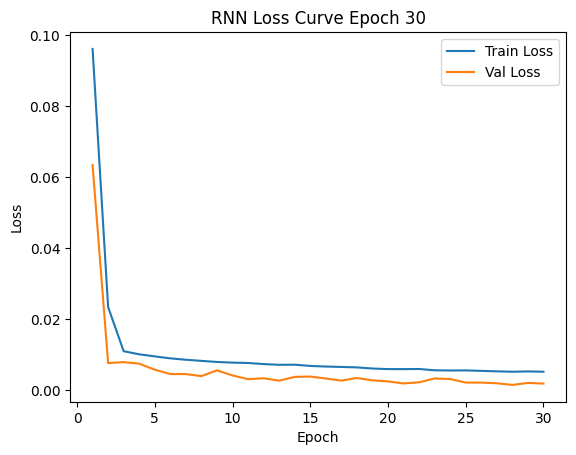

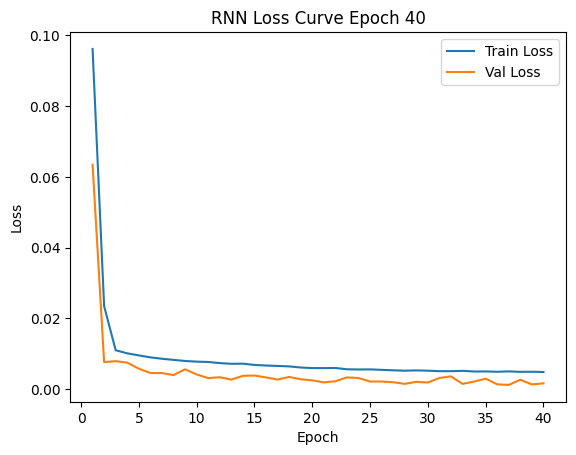

早停法触发，第47轮
RNN训练时间: 6.33 秒
RNN整个训练过程的损失曲线图


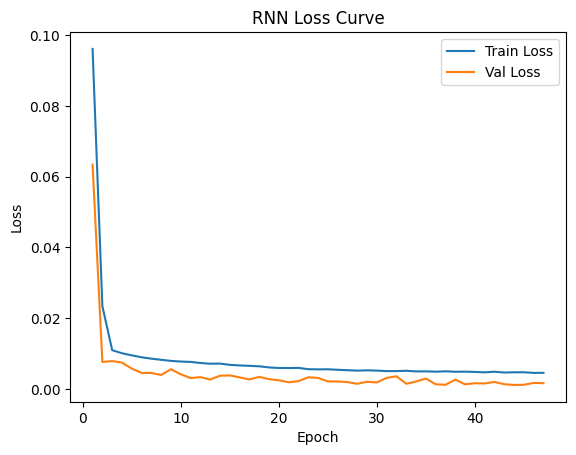

In [14]:
#设置模型训练超参数
epochs=300
patience=10
delta=0.0001
#训练模型
for model,optimizer,model_name in zip(model_list,optimizer_list,model_name_list):
    train(model,optimizer,model_name,criterion)

## 6.3 测试RNN和LSTM（复用线性回归模型处的测试函数）

In [ ]:
#测试模型
for model,model_name in zip(model_list,model_name_list):
    #载入模型参数文件⭐
    model_path=os.path.join(save_path,f'{model_name}.pth')
    model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True))
    #测试模型
    test(model,model_name)

--------------------------------------------------
LSTM的预测精度如下：
RMSE: 0.062704
MAE: 0.038427
R2 : 0.960472
--------------------------------------------------
--------------------------------------------------
RNN的预测精度如下：
RMSE: 0.061406
MAE: 0.042392
R2 : 0.962091
--------------------------------------------------


## 6.4 可视化RNN和LSTM的预测结果（服用线性回归模型处的可视化函数）

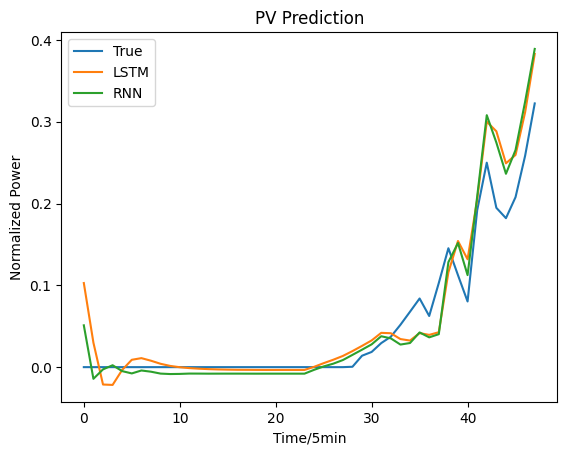

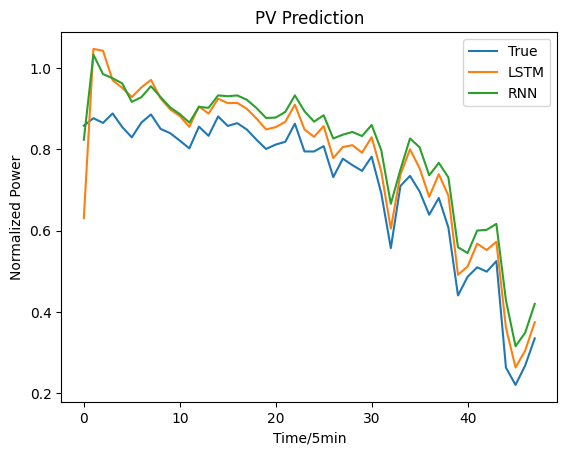

In [16]:
#可视化RNN和LSTM的预测结果
show_pred_plot(model_list,model_name_list)